# MODIS land surface temperature downsclaing form 1000m resolution to 250m with random forest regression

MODIS land surface temperature (LST) images are available at 1000m resolution. This means that every pixel of the image respresents an area of $1 km^2$. While MODIS images are available in varying times of the day their resolution is not great for the monitoring or study of the urban thermal environment. Landsat images while providing a better resolution they are only availlable once every 16 days and at the same local time of the area of interest. This code uses NDVI images from MODIS, which are provided in $250m$ resolution, as a predictor for the land surface temperature at the same scale effectively generating a new product for land surface temperature.

Modis satellite images have been preprocessed and downloaded from https://lpdaacsvc.cr.usgs.gov/appeears/ for the area of interest: Athens, Greece.

The prosess consists of the following steps:

1. Extracting the LST images
2. Using the filtered LST images to extract the coresponding NDVI images
3. Resampling the NDVI images to 1000m resolution
4. Performing random forest regression for the LST images and the resampled NDVI images
5. Performing residual corrextion on the predicted images


# Land surface temperature extraction   


## First the needed packages are imported

In [1]:
import numpy as np
import glob
import os
import rasterio
from rasterio.enums import Resampling
import rasterio.mask
import matplotlib.pyplot as plt 
import shutil
from sklearn.ensemble import RandomForestRegressor




## A simple quality mask is created based on the QA layer

In [2]:
MODIS_flags = {
    'LST_GOOD':0b0000000000000000,
    'OTHER_QA':0b0000000000010001,
    'Clouds':  0b0000000000000010,
    'LST_Err1':0b0000000001000001, 
    'LST_Err2':0b0000000001010001,
    'LST_Err3':0b0000000001100001,
'LST_PRODUCED':0b0000000010010001
  
    }
def get_mask(mask, flags_list):
    
    
    final_mask = np.zeros_like(mask)
    
    
    for flag in flags_list:
       
        flag_mask = np.bitwise_and(mask, MODIS_flags[flag])
        
       
        final_mask = final_mask | flag_mask
    
    return final_mask > 0

## The mask is applied and the resulting image is saved in the folder LST_NIGHT

In [3]:
#Paths to files should be changed accordingly to the users judgement
data_pre_dir_path = 'E:/appearstest/'
modis_LST_Night_list = glob.glob(data_pre_dir_path + '*_LST_Night_1km*.tif')
modis_QC_Night_list = glob.glob(data_pre_dir_path + '*_QC_Night*.tif')

filenames = []
for fname in modis_LST_Night_list :
    filename = os.path.basename(fname)
    filenames.append(filename)


for i in range(len(modis_LST_Night_list)):
    sds_1 = rasterio.open(modis_LST_Night_list[i])
    sds_2 = rasterio.open(modis_QC_Night_list[i])
    sds_1_np = sds_1.read(1, masked = True) * 0.02 
    sds_2_np = sds_2.read(1, masked = True)
  
    sds_2_np = None
    sds_2 = None
    with rasterio.open(
    'E:/appearstest/LST_NIGHT/'+filenames[i],
    'w',
    driver='GTiff',
    height=sds_1.shape[0],
    width=sds_1.shape[1],
    count=1,
    dtype= sds_1_np.dtype,
    crs= sds_1.crs,
    transform= sds_1.transform
    )as dst:
        dst.write(sds_1_np, 1)





## Good images are seperated from poor ones based on the number of pixels of value 0. The ratio of "black" pixels over the total of the pixels of the image is calculated to estimate a good threshold for good images. The images of LST_NIGHT are filtered based on the above criteria and saved in the folder LST_NIGHT_USABLE.


In [4]:

path = 'E:/appearstest/LST_NIGHT/'
LST_NIGHT_list = glob.glob(path + "*.tif")

for i in range(len(modis_LST_Night_list)):
    sds_3 = rasterio.open(modis_LST_Night_list[i])
    sds_3_np = sds_3.read(1)
    number_of_black_pix = np.sum(sds_3_np == 0)
    ratio = number_of_black_pix/(sds_3_np.shape[0]*sds_3_np.shape[1])
    if ratio < 0.3:
        shutil.copy('E:/appearstest/LST_NIGHT/'+filenames[i], 'E:/appearstest/LST_NIGHT_USABLE/')
    

## A crude test to confirm everything works

831
0.25462962962962965


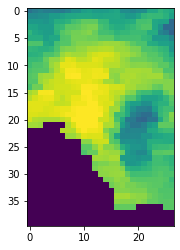

In [5]:
path = 'E:/appearstest/LST_NIGHT_USABLE/'
LST_NIGHT_USABLE_list = glob.glob(path + "*.tif")
print(len(LST_NIGHT_USABLE_list))
LST = rasterio.open(LST_NIGHT_USABLE_list[6])
LST_np = LST.read(1)
number_of_black_pix = np.sum(LST_np == 0)
ratio = number_of_black_pix/(LST_np.shape[0]*LST_np.shape[1])
print(ratio)
plt.imshow(LST_np, vmin = 290, vmax = 299)



# NDVI calculation

## Lists of the corresponding surface reflectance bands (red and near infra red) created based on the naming of the LST_NIGHT_USABLE images. (first ndvi filtering)


In [6]:
#Paths to files should be changed accordingly to the users judgement
data_pre_dir_path = 'E:/appearstest/'
data_dest_path = 'E:/appearstest/NDVI_USABLE'
LST_NIGHT_USABLE = glob.glob(data_pre_dir_path+ "LST_NIGHT_USABLE/" + "*.tif")
band_1_list=[]
band_2_list=[]
modis_QC_list=[]
filename = []

for fname in LST_NIGHT_USABLE :
    m = os.path.basename(fname)
    
    temp, tif = m.split(".tif")
    
    useless , doy = temp.split("_LST_Night_1km")
   
    band_1_list.append("E:/appearstest/MOD09GQ.006_sur_refl_b01_1"+ doy +".tif")
    band_2_list.append("E:/appearstest/MOD09GQ.006_sur_refl_b02_1"+ doy +".tif")
    modis_QC_list.append("E:/appearstest/MOD09GQ.006_QC_250m_1"+ doy +".tif")
    filename.append("E:/appearstest/NDVI/MOD09GQ.006_NDVI_250m"+ doy + ".tif")


 

   

## Calculating th NDVI images and selecting only those tha fullfill the criteria enforced by ratio and ratio2 (Second ndvi filtering)

In [7]:
for i in range(len(band_1_list)): 
    RED = rasterio.open(band_1_list[i])
    NIR = rasterio.open(band_2_list[i])
    QC_BAND = rasterio.open(modis_QC_list[i])
   

    ###Reading the bands and applaying the needed no data and quality masks 
    QC_BAND_np = QC_BAND.read(1, masked = True)
    RED_np = RED.read(1, masked = True)
    
    RED_scaled = RED_np *0.0001 
    NIR_np = NIR.read(1 ,masked = True)
    NIR_scaled = NIR_np * 0.0001
    
    np.seterr(divide='ignore', invalid='ignore')
    ###Calculating NDVI
    NDVI_np = (NIR_scaled.astype(float) - RED_scaled.astype(float))/(NIR_scaled.astype(float) + RED_scaled.astype(float))
    NDVI_np = np.where(NDVI_np<=0.05,-0.5,NDVI_np)#increasing the contrast by maximising the small values 
    
        
    number_of_light_pix = np.sum(NDVI_np >= 1)
    ratio = number_of_light_pix/(NDVI_np.shape[0]*NDVI_np.shape[1])
    number_of_black_pix = np.sum(NDVI_np <= 0)
    ratio2 = number_of_black_pix/(NDVI_np.shape[0]*NDVI_np.shape[1])

    if ratio <= 0.001 :
        if ratio2 <= 0.25:
            with rasterio.open(
            filename[i],
            'w',
            driver='GTiff',
            height=RED.shape[0],
            width=RED.shape[1],
            count=1,
            dtype= rasterio.float64,
            crs= RED.crs,
            transform= RED.transform
            )as dst:
                dst.write(NDVI_np, 1)
        
                
    


## Visualising a NDVI image

70
0.0
(158, 108)


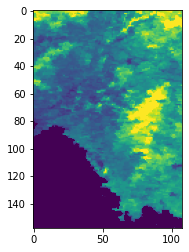

In [8]:
path = 'E:/appearstest/NDVI/'
LST_NIGHT_USABLE_list = glob.glob(path + "*.tif")
print(len(LST_NIGHT_USABLE_list))
LST = rasterio.open(LST_NIGHT_USABLE_list[0])
LST_np = LST.read(1)
number_of_black_pix = np.sum(LST_np == 0)
ratio = number_of_black_pix/(LST_np.shape[0]*LST_np.shape[1])
print(ratio)
plt.imshow(LST_np, vmin = 0, vmax = 0.5)
print(LST_np.shape)

## In order to have the same ammount of LST and NDVI images since we will later use a random forest regression algorithm to make a one to one connection between the images we will filter out all the LST images which do not have a good quality corresponding NDVI image.(LST second filtering)

In the following code block we extract the day of the year of the ndvi image and make a list of all the LST images with the same day of the year in their name, we than copy the files that are in the said list and transfer them to a new folder.

In [9]:
path_LST= 'E:/appearstest/LST_NIGHT_USABLE/'
LST_NIGHT_USABLE_LIST = glob.glob(path_LST + "*.tif")


path_NDVI= 'E:/appearstest/NDVI/'
NDVI_LIST = glob.glob(path_NDVI + "*.tif")

doy_list = []
for i in range(len(NDVI_LIST)):
    fname1 = os.path.basename(NDVI_LIST[i])
    m1 = os.path.basename(fname1)
    temp1, tif1 = m1.split(".tif")
    useless1 , ndvi_doy = temp1.split("MOD09GQ.006_NDVI_250m")
    doy_list.append('E:/appearstest/LST_NIGHT_USABLE/MOD11A1.006_LST_Night_1km'+ndvi_doy+ ".tif")


for j in range(len(LST_NIGHT_USABLE_LIST)):   
    if LST_NIGHT_USABLE_LIST[j] in doy_list:
        shutil.copy(LST_NIGHT_USABLE_LIST[j], 'E:/appearstest/LST_NIGHT_F/')
    else : 
        pass

## A crude test to check if the files were transfered

In [10]:
path_LST_F= 'E:/appearstest/LST_NIGHT_F/'
LST_NIGHT_F_list = glob.glob(path_LST_F + "*.tif")
print(len(LST_NIGHT_F_list))

path_NDVI= 'E:/appearstest/NDVI/'
NDVI_LIST = glob.glob(path_NDVI + "*.tif")
print(len(NDVI_LIST))

70
70


# Resampling the NDVI images  
Each pixel's side is 250m and therefore the NDVI images have 16 times more pixels than the LST images of 1000m each side. The images are resampled to a "worse" resolution via mean aggregation in order for the machine learning model to be later trained on images of the same resolution-dimention.

In [11]:
data_pre_dir_path = 'E:/appearstest/NDVI_USABLE/'
NDVI_USABLE_list = glob.glob(data_pre_dir_path + '*.tif')
a = np.empty((40,27)) 

for i in range(len(NDVI_USABLE_list)):
    filename = os.path.basename(NDVI_USABLE_list[i])
    upscale_factor = 1/4

    with rasterio.open(NDVI_USABLE_list[i]) as dataset:

        
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.average
        )
        data = np.where(data <= 0.05, 0, data )

    #show(data)
    with rasterio.open(
    'E:/appearstest/NDVI_TRAINING/250'+filename,
    'w',
        driver='GTiff',
        height=a.shape[0],
        width=a.shape[1],
        count=1,
        dtype= data.dtype,
        crs= dataset.crs,
        transform= dataset.transform
        )as dst:
            dst.write(data)

## Fast test to check if the image has been resampled correctly

(40, 27)


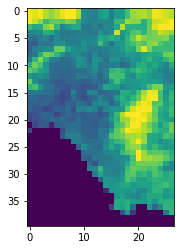

In [12]:
path = 'E:/appearstest/NDVI_TRAINING/'
testlist = glob.glob(path +'*.tif')
test = rasterio.open(testlist[4])
test_np = test.read(1,masked = True)
print(test_np.shape)
plt.imshow(test_np,vmin = 0,vmax=0.5)
plt.show()

# Random Forest Regression

In [13]:
predictor_train_set_path = "E:/appearstest/NDVI_TRAINING/"
predictor_train_set_list = glob.glob(predictor_train_set_path + "*.tif")

label_train_set_path = "E:/appearstest/LST_NIGHT_F/"
label_train_set_list = glob.glob(label_train_set_path + "*.tif")

test_set_path = "E:/appearstest/NDVI/"
test_set_list = glob.glob(test_set_path + "*.tif")

filenames = []
for fname in label_train_set_list :
     filename = os.path.basename(fname)
     filenames.append(filename)
print(len(filenames))
print(len(test_set_list))

70
70


## Looping through the files, reading them and "clipping" them to vallues that will impose meaning to the imaging and reduce noise therefore compiling time. 

Since the algorith will be trained to correlate vectors of 1000m resolution to 1000m which have 16 times less pixels than 250m vectors we split the test set into smaller arrays on which we will perform the prediction and then reassemble into a full 250m resolution image print(test_set_np.shape)

In [14]:
for i in range(len(label_train_set_list)):
 
    label_train_set = rasterio.open(label_train_set_list[i])
    label_train_set_np = label_train_set.read(1,masked = False)
    label_train_set_np = np.clip(label_train_set_np, 280,label_train_set_np.max())
    label_train_set_np = label_train_set_np.reshape(-1, 1).flatten()
    

    predictor_train_set = rasterio.open(predictor_train_set_list[i])
    predictor_train_set_np = predictor_train_set.read(1,masked = False)
    predictor_train_set_np = np.clip(predictor_train_set_np,-0.5,0.5)
    predictor_train_set_np = predictor_train_set_np.reshape(-1, 1)
   
    
    test_set = rasterio.open(test_set_list[i])
    test_set_np = test_set.read(1, masked = False)
    empty = np.full((2,108), 0,float)
    test_set_np = np.append(test_set_np,empty,axis = 0) #fixing vector size since random forest regression requires same length vectors to work
    split = np.array_split(test_set_np, 4, axis = 0) #since the algorith will be trained to correlate vectors of 1000m resolution to 1000m which have 16 times less pixels than 250m vectors we split the test set into smaller arrays 
    #on which we will perform the prediction and then reassemble into a full 250m resolution image
    # print(test_set_np.shape)
    new_l = []
    for j in range(len(split)):
        split_2 = np.array_split(split[j], 4 , axis = 1)
        new_l += split_2
        

    x_train = predictor_train_set_np
    y_train = label_train_set_np
    

    regressor = RandomForestRegressor(n_estimators=100,random_state=0)
    regressor.fit(x_train, y_train)
    final = []
    
    for k in range(len(new_l)):
        temp = new_l[k].reshape(-1, 1)
        y_pred = regressor.predict(temp)
        y_pred = y_pred.reshape(40,27)
        final.append(y_pred)

    
    r1 = np.concatenate((final[0],final[1],final[2],final[3]), axis = 1)
    r2 = np.concatenate((final[4],final[5],final[6],final[7]),axis = 1)
    r3 = np.concatenate((final[8],final[9],final[10],final[11]), axis = 1)
    r4 = np.concatenate((final[12],final[13],final[14],final[15]), axis = 1)
    
    image = np.concatenate((r1,r2,r3,r4), axis = 0)
    
    predictor_train_set_np = None
    test_set_np = None

    with rasterio.open(
        'E:/appearstest/PREDICTIONS/PRED_'+filenames[i],
        'w',
        driver='GTiff',
        height=image.shape[0],
        width=image.shape[1],
        count=1,
        dtype= label_train_set_np.dtype,
        crs= label_train_set.crs,
        transform= label_train_set.transform
        )as dst:
         dst.write(image, 1)
    
label_train_set_np = None 

# Residual Correction

In [15]:
data_pre_dir_path = 'E:/appearstest/PREDICTIONS/'
pred_list = glob.glob(data_pre_dir_path + '*.tif')#filename to be updated based on NDVI product naming

original = 'E:/appearstest/LST_NIGHT_F/'
original_list = glob.glob(original + '*.tif')
print(len(pred_list))

a = np.empty((40,27)) # to be updated with the size of LST in appears 
for i in range(len(pred_list)):
    filename = os.path.basename(pred_list[i])
    lst = rasterio.open(original_list[i])
    lst_np = lst.read(1,masked = True)

    upscale_factor = 1/4

    with rasterio.open(pred_list[i]) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.average
        )
    

    residual = lst_np - data

    with rasterio.open(
    'E:/appearstest/RESIDUAL/RES'+filename,#to be created as a folder and the name to be generated 
    'w',
        driver='GTiff',
        height=a.shape[0],
        width=a.shape[1],
        count=1,
        dtype= data.dtype,
        crs= dataset.crs,
        transform= dataset.transform
        )as dst:
            dst.write(residual)

70


In [18]:
respath = 'E:/appearstest/RESIDUAL/'
res_list = glob.glob(respath + '*.tif')
downscale_factor = 4
b = np.empty((160,108))
print(len(res_list))
data_pre_dir_path = 'E:/appearstest/PREDICTIONS/'
pred_list = glob.glob(data_pre_dir_path + '*.tif')#filename to be updated based on NDVI product naming
for i in range(len(pred_list)):
    filename = os.path.basename(pred_list[i])
    #print(filename)
    pred_temp = rasterio.open(pred_list[i])
    pred_temp_np = pred_temp.read(1, masked = True)
    upscale_factor = 4

    with rasterio.open(res_list[i]) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.average
        )
    

    final = pred_temp_np + data

    with rasterio.open(
    'E:/appearstest/RES_CORRECTED/COR'+filename,#to be created as a folder and the name to be generated 
    'w',
        driver='GTiff',
        height=b.shape[0],
        width=b.shape[1],
        count=1,
        dtype= data.dtype,
        crs= dataset.crs,
        transform= dataset.transform
        )as dst:
            dst.write(final)
print(len(pred_list))

70
70
